In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `c:\Users\sesch\Git\tinympc-julia\quadrotor_quat\Project.toml`


In [2]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random
using Printf
using MeshCat
using TrajOptPlots
using RobotZoo:Quadrotor
using StaticArrays
using GeometryTypes
using ColorTypes

In [80]:
vis = Visualizer()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat C:\Users\sesch\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat Visualizer with path /meshcat at http://127.0.0.1:8703

In [81]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [5]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [6]:
# Quadrotor parameters
m = 0.035
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008
ℓ = 0.046/sqrt(2)
scale = 65535
kt = 2.245365e-6*scale # u is PWM in range [0...1]
# kt=1
km = kt*thrustToTorque #4.4733e-8

h = 1/500

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4      # number of controls
nx = Nx̃
nu = Nu

4

In [7]:
function quad_dynamics(x,u)
  r = x[1:3]
  q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)
  
  ṙ = v
  q̇ = 0.5*L(q)*H*ω
  
  v̇ = [0; 0; -g] + (1/m)*Q*[zeros(2,4); kt*ones(1,4)]*u 

  ω̇ = J\(-hat(ω)*J*ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; -ℓ*kt ℓ*kt ℓ*kt -ℓ*kt; -km km -km km]*u)
  
  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5*h*f1, u)
  f3 = quad_dynamics(x + 0.5*h*f2, u)
  f4 = quad_dynamics(x + h*f3, u)
  xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
  xn[4:7] = xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [8]:
#Goal state
@show uhover = (m*g/kt/4)*ones(4) # m = 30g and max thrust = 60g
# @show uhover = (m*g/4)*ones(4) # m = 30g and max thrust = 60g
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

uhover = (((m * g) / kt) / 4) * ones(4) = [0.5833333520642209, 0.5833333520642209, 0.5833333520642209, 0.5833333520642209]


In [9]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u
end

discrete_dynamics (generic function with 1 method)

In [82]:
Tfinal = 5.0            # final time
N = Int(Tfinal/h)+1     # number of time steps
t_vec = h*(0:N-1)

# Cost weights
Q = Array(BlockDiagonal([5.0*I(3), 0.001*I(Nx̃-3)]));
R = Array(1*I(Nu));
Qf = 1*Q;

# Penalty
ρ = 5
R̃ = R + ρ*I;

# Precompute
cache = (
    Ã = Ã,
    B̃ = B̃,
    Kinf = zeros(nu,nx),
    Pinf = zeros(nx,nx),
    Quu_inv = zeros(nu,nu),
    AmBKt = zeros(nx,nx), 
    coeff_d2p = zeros(nx,nu), 
)

P = [zeros(nx,nx) for i = 1:N];   # cost to go quadratic term
P[N] = Qf

K = [zeros(nu,nx) for i = 1:N-1]; # feedback gain

P[N] .= Qf;
for k = (N-1):-1:1
    K[k] = (R̃ + B̃'*P[k+1]*B̃)\(B̃'*P[k+1]*Ã);
    P[k] = Q + Ã'*P[k+1]*(Ã - B̃*K[k]);
end

cache.Kinf .= K[1];
cache.Pinf .= P[1];
cache.Quu_inv .= (R̃ + cache.B̃'*cache.Pinf*cache.B̃)\I;
cache.AmBKt .= (cache.Ã - cache.B̃*cache.Kinf)';
cache.coeff_d2p .= cache.Kinf'*R̃ - cache.AmBKt*cache.Pinf*cache.B̃;


# Create trajectory to follow
X̃ref = [zeros(nx) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

# Figure-eight
scale = 1
loops = 1
Xref = [[scale*sin(2*t)/2; scale*cos(t); 1; 1; zeros(9)] for t = range(-pi/2*loops, 3*pi/2*loops, length = N)];

# Compute reference velocity from reference position
for i = 1:N-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/h
end

for k = 1:N
    x = Xref[k]
    qx = x[4:7]
    ϕ = qtorp(L(qg)'*qx)   
    X̃ref[k] = [x[1:3]; ϕ; x[8:10]; x[11:13]]
end


# u_min = 0.1*[1; 1; 1; 1] - uhover
# u_max =  uhover - 0.1*[1; 1; 1; 1] 
u_min = -[1.0; 1.0; 1.0; 1.0]*.5
u_max = [1.0; 1.0; 1.0; 1.0]*.5

# # state constraints (box)
# x_min = -100*ones(nx)
# x_min[3] = -0.2
# x_max = 100*ones(nx)
# x_max[3] = 0.2


# Visualize reference
delete!(vis["XrefLine"])
XrefLine = [Point(x_[1], x_[2], x_[3]) for x_ in Xref]
setobject!(vis["XrefLine"], Object(PointCloud(XrefLine), 
        LineBasicMaterial(color=Colors.RGBA(0.,0.45,1.)), "Line"))
;

In [100]:
include("../tinyMPC-ADMM-dt.jl")

# MPC setup
Nh = N-4 # ((N-1)-2)-1 since Nsim = N-Nh so Nsim = N - (N-4) = 4 and k = 1:N-3 so k = 1:1
Nsim = N - Nh

# xhist = [zeros(nx+1) for i = 1:Nsim] # nx+1 because not reduced form
# xhist[1] = Xref[1]
# uhist = [zeros(nu) for i = 1:Nsim-1]
xhist = [zeros(nx+1) for i = 1:N-2] # nx+1 because not reduced form
xhist[1] = Xref[1]
uhist = [zeros(nu) for i = 1:N-3]

Δu = 0
x = 0


# Simulation
# for k = 1:Nsim-1 # Nsim-1 knotpoints for control, Nsim knotpoints for state
for k = 1:N-3 # 1:N-1-2, since Nh >= 2
    if k == N - Nh
        Nh -= 1
    end
    x = [zeros(nx) for i = 1:Nh]
    # x[1] = X̃ref[k]
    x[1] = [xhist[k][1:3]; qtorp(xhist[k][4:7]); xhist[k][8:end]]
    # x[1][1:3] .= [-0.2; 0.1; 1.1]
    u = [zeros(nu) for i = 1:Nh-1]

    z = [zeros(nu) for i = 1:Nh-1]
    znew = [zeros(nu) for i = 1:Nh-1]
    y = [zeros(nu) for i = 1:Nh-1]

    q = [zeros(nx) for i = 1:Nh];
    r = [zeros(nu) for i = 1:Nh-1];

    p = [zeros(nx) for i = 1:Nh];      # cost to go linear term
    p[Nh] = q[Nh];

    d = [zeros(nu) for i = 1:Nh-1];    # feedforward control

    params = (
        Q = Q, R = R, Qf = Qf,
        umin = u_min, umax = u_max,
        Xref = X̃ref[k:k+Nh-1], Uref = Uref[k:k+Nh-2], 
        cache = cache
    );

    # Solve
    Δu, status, iter = solve_admm!(vis, params, q, r, p, d, x, u, z, znew, y; ρ=ρ, abs_tol=1e-2, max_iter=2000)
    # @show iter, status

    # Roll out x_k+1 with actual dynamics
    uhist[k] = Δu[1] + uhover
    xhist[k+1] = quad_dynamics_rk4(xhist[k], uhist[k])

    # Visualize solution x
    delete!(vis["xLinearized"])
    x_linearized = [Point(x_[1], x_[2], x_[3]) for x_ in x]
    setobject!(vis["xLinearized"], Object(PointCloud(x_linearized), 
    LineBasicMaterial(color=Colors.RGBA(1,0.6,0.0)), "Line"))
end

In [96]:
X1 = [SVector{13}([x_[1:3]; rptoq(x_[4:6]); x_[7:9]; x_[10:12]]) for x_ in x];
visualize!(vis, model, t_vec[Nh], X1)

In [97]:
delete!(vis["xHistline"])
xHistline = [Point(x_[1], x_[2], x_[3]) for x_ in xhist]
setobject!(vis["xHistline"], Object(PointCloud(xHistline), 
LineBasicMaterial(color=Colors.RGBA(0.75,0.5,0.8)), "Line"))

MeshCat Visualizer with path /meshcat/xHistline at http://127.0.0.1:8703

In [99]:
# X1 = [SVector{13}([x_[1:3]; rptoq(x_[4:6]); x_[7:9]; x_[10:12]]) for x_ in x_deltas];
X1 = [SVector{13}(x_) for x_ in xhist];
visualize!(vis, model, t_vec[Nsim], X1)

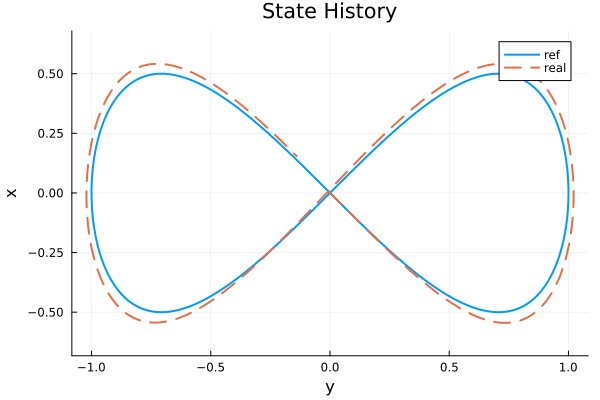

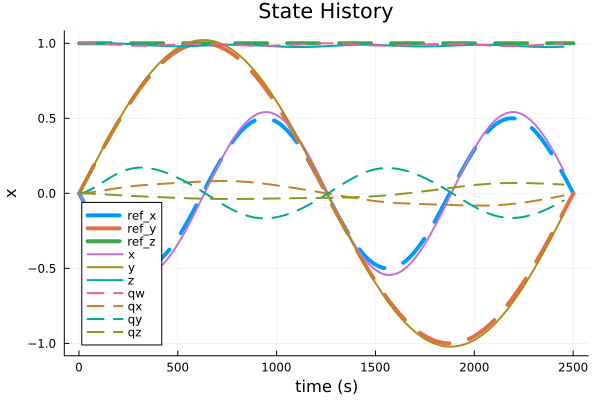

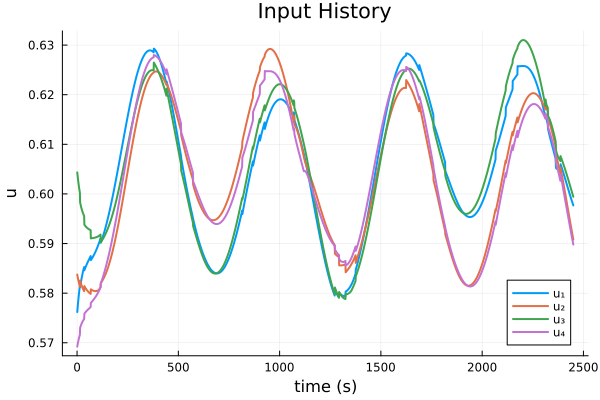

In [79]:
Xsim_m = hcat(xhist...)
Usim_m = hcat(uhist...)
Xref_m = hcat(Xref...)
plot(Xref_m[2,:], Xref_m[1,:], label="ref", linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")

display(plot!(Xsim_m[2,:], Xsim_m[1,:], label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))


plot(Xref_m[1:3,:]',label=["ref_x" "ref_y" "ref_z"],
linestyle=[:dash :dash :dash], linewidth=[4 4 4])

display(plot!(Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
            title="State History", xlabel="time (s)", ylabel="x"))
            
display(plot(Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
            title="Input History", linewidth=[2 2 2 2 2 2 2],
            xlabel="time (s)", ylabel="u"))
# norm(xhist[1:Nsim]-1*Xref[1:Nsim])

In [632]:
# # Simulation
# uhist = [zeros(Nu) for i in 1:Nt-1]
# xhist = [zeros(Nx) for i in 1:Nt]
# # xhist[1] .= [rg+1*randn(3)/3 + [0.0, 0.0, 1.0]; L(qg)*rptoq([0; 0; 0]); vg; ωg]  # initial conditions
# xhist[1] .= Xref[1]
# # backward_pass!(Q,qq,R̃,r,P,p,K,d,params)
# Nsim = Nt - N
# for k = 1:Nsim
# # for k = 1:3
#     params1 = update_reference(params, k)
#     # display(params1.Xref)
#     # display(xhist[k])
#     uhist[k] = controller_mpc(params1, xhist[k], k)
#     # uhist = controller_mpc(params1, xhist[k], k)
#     # uhist[k] = clamp.(uhist[k], (uhover+u_min)[1], (uhover+u_max)[1])
#     xhist[k+1] = quad_dynamics_rk4(xhist[k],uhist[k])
# end

In [633]:
function export_mat_to_c(declare, data)
  str = "static sfloat " * declare * " = {\n"
  dataT = data'
  for i = 1:size(dataT, 1)
      str = str * "  "
      for j = 1:size(dataT, 2)
          this_str = @sprintf("%.6f", dataT[i, j])
          str = str * this_str * "f,"
      end
      str = str * "\n"
  end
  str = str * "};\n"
  return str
end

@printf("%s",export_mat_to_c("Kinf_data[NINPUTS*NSTATES]", cache.Kinf))
@printf("%s",export_mat_to_c("Pinf_data[NSTATES*NSTATES]", cache.Pinf))
@printf("%s",export_mat_to_c("Quu_inv_data[NINPUTS*NINPUTS]", cache.Quu_inv))
@printf("%s",export_mat_to_c("AmBKt_data[NSTATES*NSTATES]", cache.AmBKt))
@printf("%s",export_mat_to_c("coeff_d2p_data[NSTATES*NINPUTS]", cache.coeff_d2p))
@printf("%s",export_mat_to_c("Q_data[NSTATES*NSTATES]", Q))
@printf("%s",export_mat_to_c("R_data[NINPUTS*NINPUTS]", R))
@printf("%s\n",export_mat_to_c("A_data[NSTATES*NSTATES]", Ã))
@printf("%s\n",export_mat_to_c("B_data[NSTATES*NINPUTS]", B̃))
# @printf("%s",export_mat_to_c("Kinf_data[NINPUTS*NSTATES]", cache.Kinf2))
# @printf("%s",export_mat_to_c("Pinf_data[NSTATES*NSTATES]", cache.Pinf2))
# @printf("%s",export_mat_to_c("Quu_inv_data[NINPUTS*NINPUTS]", cache.Quu_inv2))
# @printf("%s",export_mat_to_c("AmBKt_data[NSTATES*NSTATES]", cache.AmBKt2))
# @printf("%s",export_mat_to_c("coeff_d2p_data[NSTATES*NINPUTS]", cache.coeff_d2p2))

static sfloat Kinf_data[NINPUTS*NSTATES] = {
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,
};
static sfloat Pinf_data[NSTATES*NSTATES] = {
  0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,

static sfloat R_data[NINPUTS*NINPUTS] = {
  1.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,1.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,1.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,1.000000f,
};
static sfloat A_data[NSTATES*NSTATES] = {
  1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,-0.000039f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,-0.039240f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000039f,0.000000f,0.000000f,0.000000f,1.000000f,0.000000f,0.039240f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
 

In [634]:
function export_mat_to_eigen(prefix, data)
  str = prefix * "\n"
  for i = 1:size(data, 1)
      for j = 1:size(data, 2)
          this_str = @sprintf("%.6f", data[i, j])
          str = str * this_str * "f"
          if (i == size(data, 1) && j == size(data, 2))
            str = str * ";"
          else
            str = str * ","
          end
      end
      str = str * "\n"
  end
  str = str * "\n"
  return str
end

open("params_dt"*".h","w") do io
  @printf(io, "%s",export_mat_to_eigen("Kinf << ", cache.Kinf))
  @printf(io, "%s",export_mat_to_eigen("Pinf << ", cache.Pinf))
  @printf(io, "%s",export_mat_to_eigen("A << ", Ã))
  @printf(io, "%s",export_mat_to_eigen("B << ", B̃))
  @printf(io, "%s",export_mat_to_eigen("Quu_inv << ", cache.Quu_inv))
  @printf(io, "%s",export_mat_to_eigen("AmBKt << ",   cache.AmBKt))
  @printf(io, "%s",export_mat_to_eigen("coeff_d2p << ", cache.coeff_d2p))
  
  @printf(io, "%s",export_mat_to_eigen("Q << ", Q))
  @printf(io, "%s",export_mat_to_eigen("R << ", R))
end

In [635]:

# Export a vector of vectors to C header and source 
function export_vec_to_c(filename, var_type, var_name, data, flag)
  declare = var_type * " " * var_name
  def = declare * " = {\n"
  for i = 1:length(data)
    def = def * "  "
    for j = 1:length(data[1])
      def = def * @sprintf("%.4f", data[i][j])
      if j < length(data[1])
        def = def * ","
      end
    end
    if i < length(data)
      def = def * ",\n"
    end
  end
  def = def * "}"

  open(filename * ".h", flag) do io
    println(io, def * ";\n")
  end
  return true
end
###################

# X_ref_data = [xhist[i][1:nx] for i = 1:Nt-N]
X_ref_data = [[xhist[i][1:3]-rg; qtorp(L(qg)'*xhist[i][4:7]); xhist[i][8:10]-vg; xhist[i][11:13]-ωg] for i = 1:Nt-N]
interpl_step = Int(500/freq1)
X_ref_data1 = [zeros(nx) for i = 1:(Nt-N)*interpl_step]
for k = 1:Nt-N-1
  X_ref_data1[((k-1)*interpl_step+1):k*interpl_step] .= collect(LinRange(X_ref_data[k], X_ref_data[k+1], interpl_step+1))[1:interpl_step]
end

export_vec_to_c("data", "static const float", "X_ref_data[]", X_ref_data1, "w")

UndefVarError: UndefVarError: freq1 not defined

In [636]:
U_ref_data = [uhist[i][1:nu] - uhover for i = 1:Nt-N-1]
U_ref_data1 = [zeros(nx) for i = 1:(Nt-N-1)*interpl_step]
for k = 1:Nt-N-2
  U_ref_data1[(k-1)*interpl_step+1:k*interpl_step] .= collect(LinRange(U_ref_data[k], U_ref_data[k+1], interpl_step+1))[1:interpl_step]
end
export_vec_to_c("data", "static const float", "U_ref_data[]", U_ref_data1, "a")

UndefVarError: UndefVarError: interpl_step not defined